## Explore emoji dataset

First I'd like to know how our labels are distributed

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import string
import numpy as np
import scipy.stats as stats
import nltk
from nltk.corpus import stopwords
from nltk import ngrams
from collections import Counter
from wordcloud import WordCloud

In [2]:
#Load datasets
train_set = pd.read_csv('dataset/emoji_dataset/train.csv',index_col=False)
test_set = pd.read_csv('dataset/emoji_dataset/test.csv',index_col=False)
validation_set = pd.read_csv('dataset/emoji_dataset/val.csv',index_col=False)

Our dataset is unbalanced. Still, the proportion of labels is consistant across the different labels.

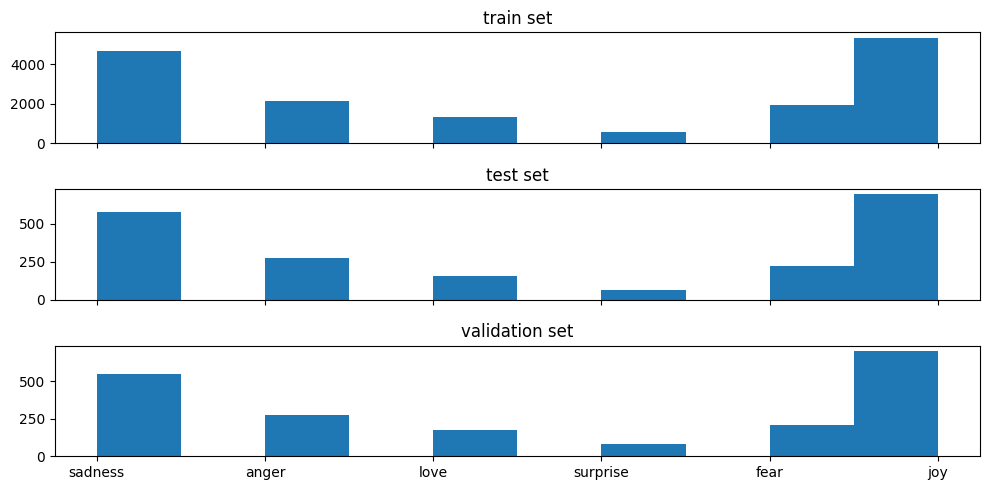

In [3]:
#Check if they are balanced/distributed
fig, ax = plt.subplots(3,1,sharex=True,figsize=(10,5))
ax[0].hist(train_set.emoji)
ax[0].set_title("train set")
ax[1].hist(test_set.emoji)
ax[1].set_title("test set")
ax[2].hist(validation_set.emoji)
ax[2].set_title("validation set")
plt.tight_layout()

The original dataset removed every apostrophe so contractions have a space in between them. Also, there are instances on which there is missing apostrophe without space.
Another anomaly is that there are remnants of URLS. The following function attemtps to clean it as much as possible.

In [4]:
#Cleaning function
import re
def tweet_clean(tweet):
    replaceables = [('a href https www',''),(' t ','\'t '),(' s ','\'s '),(' m ','\'m '),(' ve ','\'ve')]
    for target, new in replaceables:
        tweet = tweet.replace(target, new)
    tweet = re.sub(r"\bim\b", "i\'m", tweet)
    tweet = re.sub(r"\bive\b", "i\'ve", tweet)
    tweet = ' '.join([word for word in tweet.split() if word not in ['http','https','www','href']])
    return tweet

To get better insights on our dataset I'll show how the tweet lenght is distributed across each label. To do so I'll put together the three sets, clean each text and get their lenghts. 
I'll also show how many instances of each label we have in total.

In [5]:
full_set = pd.concat([train_set,test_set,validation_set],axis=0)
print(full_set['emoji'].value_counts())

emoji
joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: count, dtype: int64


In [6]:
#Preprocess data
full_set['text_clean'] = full_set['text'].apply(tweet_clean)
full_set['lenght_clean'] = full_set['text_clean'].str.split().str.len()

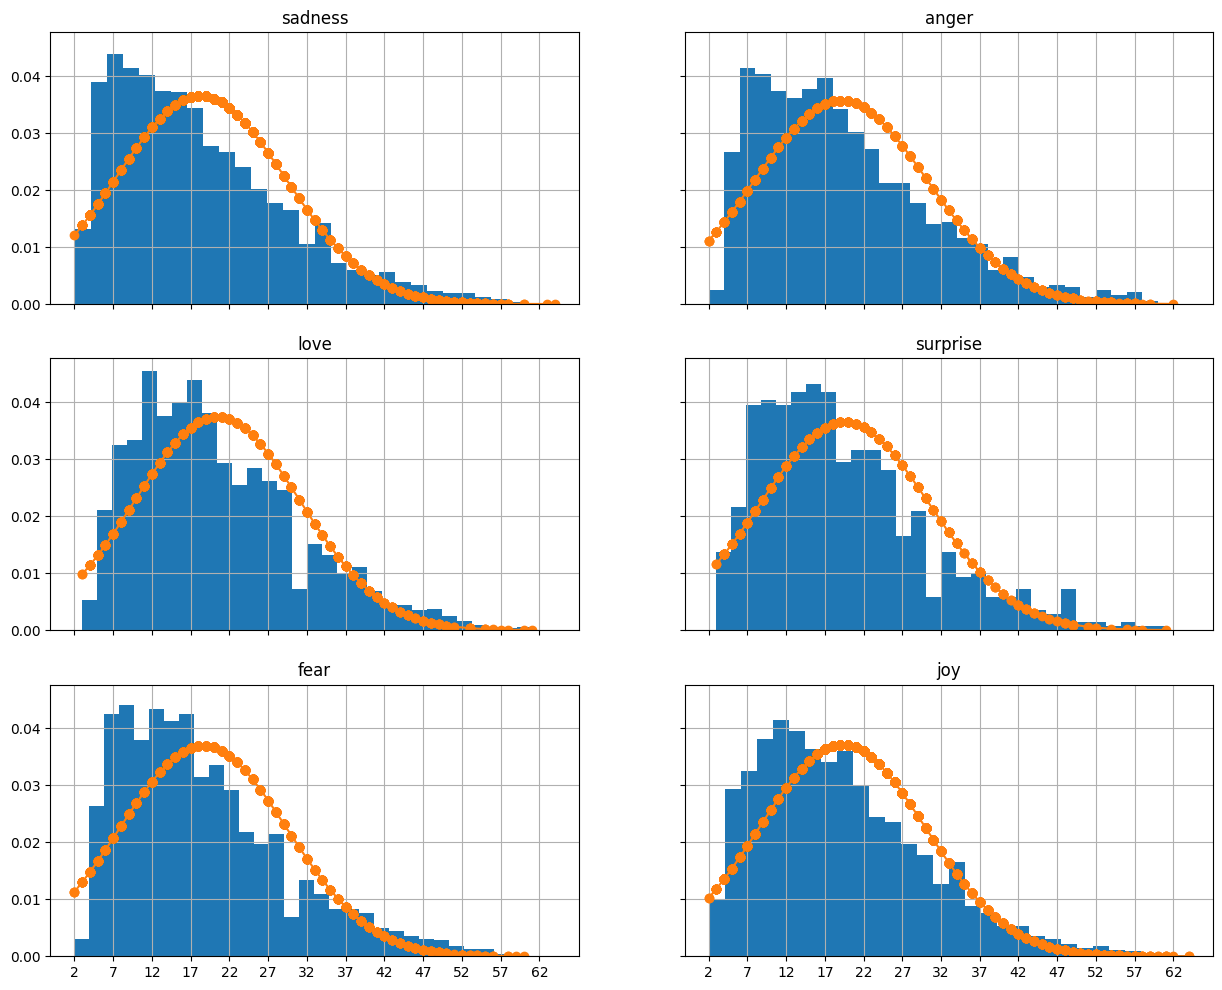

In [7]:
emojis = full_set['emoji'].unique()
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 12),sharex=True, sharey=True)
plt.xticks(np.arange(min(full_set['lenght_clean'].values), max(full_set['lenght_clean'].values)+1, 5))
for emoji, ax in zip(emojis, ax.ravel()):
    temp_dst = full_set[full_set['emoji'] == emoji]['lenght_clean']#.value_counts()
    fit = stats.norm.pdf(temp_dst.sort_values(), np.mean(temp_dst.sort_values()), np.std(temp_dst.sort_values()))
    ax.hist(temp_dst.sort_values(),density=True,bins=30)
    ax.plot(temp_dst.sort_values(),fit,'-o')
    ax.grid(True)
    ax.set_title(emoji)

We observe that the majority of texts, independently from the label, have between 7 and 32 characters.

Next, I thought it would be fun to see what are the most common words per class. 

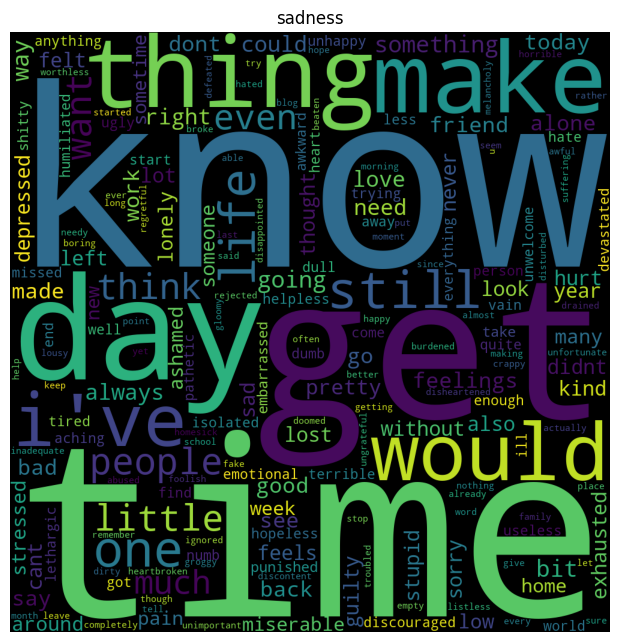

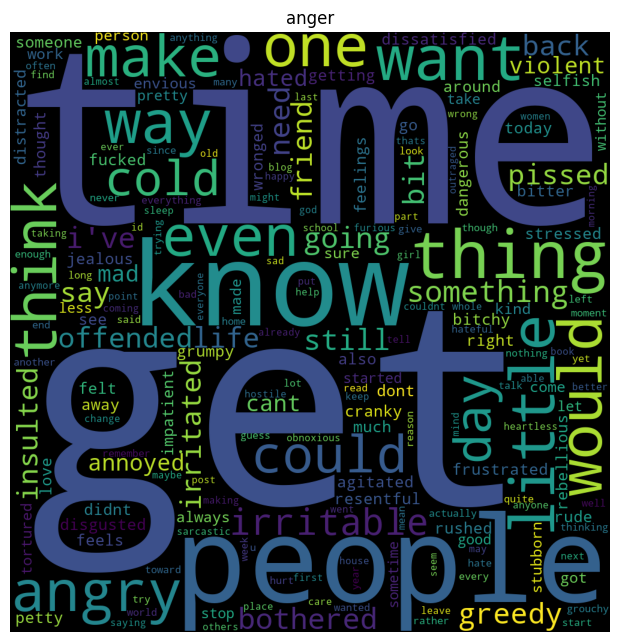

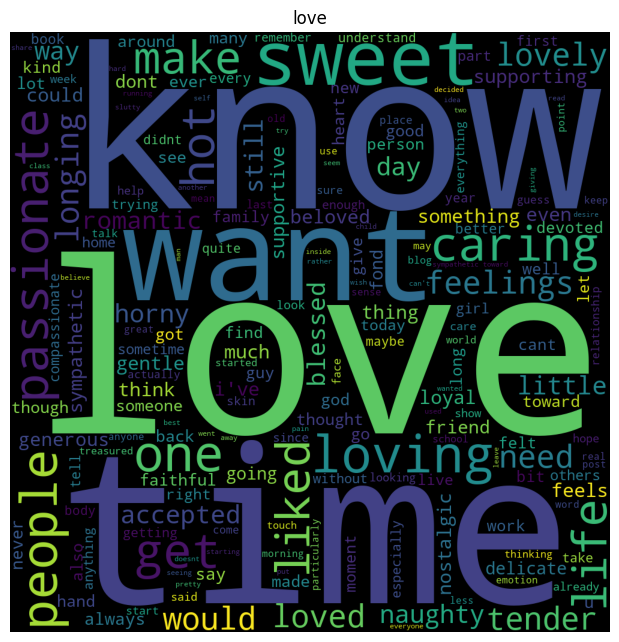

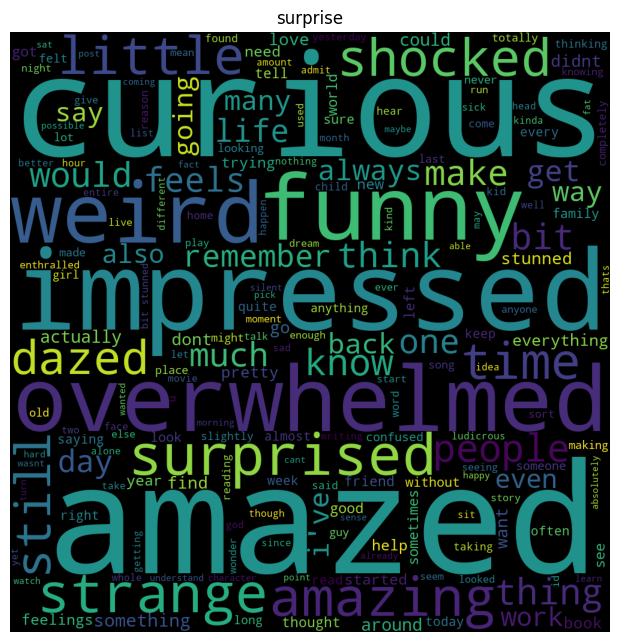

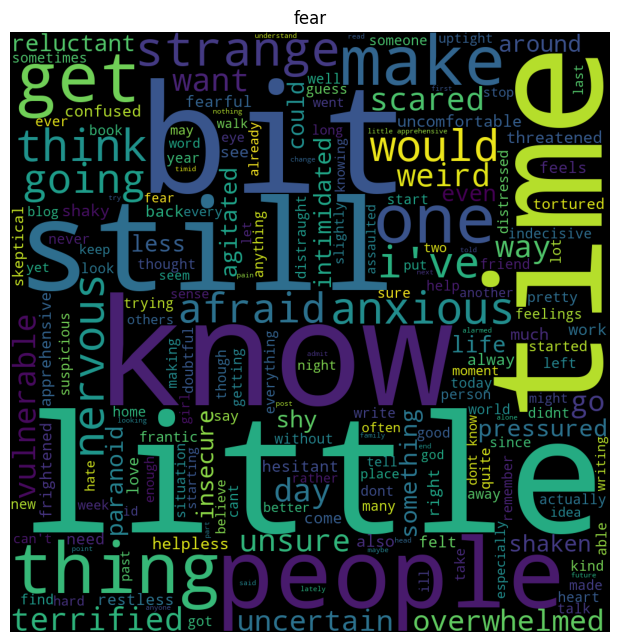

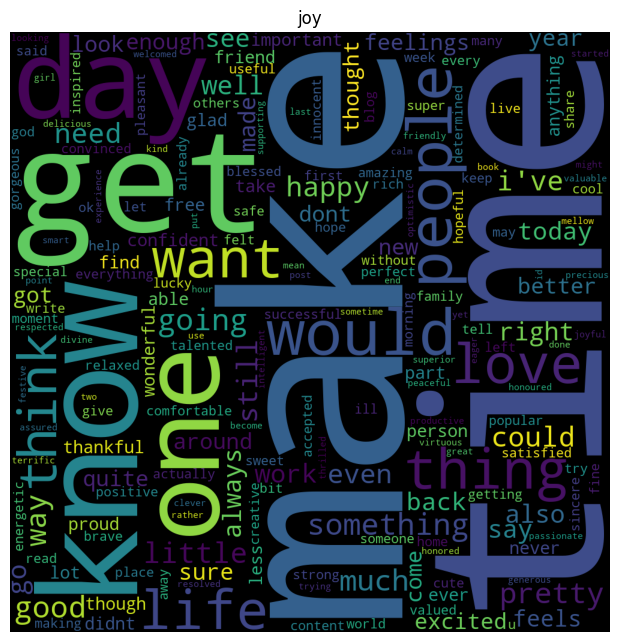

In [12]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))

remove = list(stop_words) + ['feel','feeling','really','like','im','i\'m']
for emoji in emojis:
    temp_dataset = " ".join(full_set[full_set['emoji'] == emoji]['text_clean'])
    wordcloud = WordCloud(width =1000, height = 1000, stopwords=remove,min_font_size = 12,).generate(temp_dataset)
    plt.figure(figsize = (6, 6), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(emoji)
    plt.show()

Finally, save the cleaned original dataset to train our models. I'm also saving a balanced version (I tried this on the transfer-learning model and the results weren't better since its very small)

In [15]:
#Clean and save dataset.
train_set_clean = train_set
train_set_clean['text'] = train_set_clean['text'].apply(tweet_clean)
test_set_clean = test_set
test_set_clean['text'] = test_set_clean['text'].apply(tweet_clean)
val_set_clean = validation_set
val_set_clean['text'] = val_set_clean['text'].apply(tweet_clean)

In [16]:
train_set_clean.to_csv('dataset/train_clean.csv',index=False)
test_set_clean.to_csv('dataset/test_clean.csv',index=False)
val_set_clean.to_csv('dataset/val_clean.csv',index=False)

In [19]:
#Undersample to smallest label.
complete = pd.concat([train_set_clean,test_set_clean,val_set_clean], axis=0)
sample_size = 1000
bigger_mask = complete.groupby('emoji')['emoji'].transform('size') >= sample_size
complete = pd.concat((complete[bigger_mask].groupby('emoji').sample(n=sample_size), complete[~bigger_mask]), ignore_index=True)

#Split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(complete, complete['emoji'], test_size=0.2, stratify=complete['emoji'])
X_train, X_test, y_train, y_test = train_test_split(X_train, X_train['emoji'], test_size=0.25, stratify=X_train['emoji'])

X_train.to_csv('dataset/train_balanced_clean.csv',index=False)
X_test.to_csv('dataset/test_balanced_clean.csv',index=False)
X_val.to_csv('dataset/val_balanced_clean.csv',index=False)
